In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import math
import io
from pprint import pprint
import os
from sklearn import preprocessing
from datetime import datetime, timedelta
from typing import List
import itertools
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
def parse(path: str) -> pd.DataFrame:
    # CSVから読み取る
    try:
        df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])
    except Exception as e:
        raise(e)
    df_target = df.to_numpy()

    # いい感じに整形
    requests = pd.DataFrame([{"date": datetime.fromtimestamp(float(d[4])/1000), "status": d[6], "count": 1} for d in df_target if (d[0] == "REQUEST" and not math.isnan(float(d[4])) )])
    if len(requests) == 0:
        return pd.DataFrame([])

    # 1秒ごとにサマる
    grouped1 = requests.groupby([pd.Grouper(key=("status")),pd.Grouper(key=("date"), freq="S")]).sum().reset_index()

    # 全部同じ数は困るので乱数を入れておく
    for x in range(len(grouped1)):
        grouped1.iat[x, 2] += np.random.rand() * sys.float_info.epsilon

    return grouped1

In [3]:
def reg_tree() -> DecisionTreeRegressor:
    X = [
        [60],
        [100],
        [140],
        [175],
        [210],
        [255],
        [300],
        [330],
        [360],
        [390],
        [420],
        [460],
        [500],
        [540],
        [580],
        [610],
        [640],
        [670],
        [700],
        [730],
        [760],
        [790],
        [820],
        [850],
        [880],
        [910],
        [940],
        [970],
        [1000],
        [1030],
        [1060],
    ]

    y = [
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30,
        31,
        32,
        33,
        34,
    ]

    return DecisionTreeRegressor().fit(X, y)

In [4]:
fuzzy_cluster_size_01 = pd.read_csv("../fuzzy20230405/fbv1_hpq.log", names=["date", "size"])
fuzzy_cluster_size_01["date"] = pd.to_datetime(fuzzy_cluster_size_01["date"], utc = False) + pd.to_timedelta(9, unit='h')
fuzzy_cluster_size_01

,date,size
0,2023-05-04 22:17:27+00:00,8
1,2023-05-04 22:17:28+00:00,8
2,2023-05-04 22:17:29+00:00,8
3,2023-05-04 22:17:30+00:00,8
4,2023-05-04 22:17:32+00:00,8
...,...,...
653,2023-05-04 22:29:36+00:00,16
654,2023-05-04 22:29:37+00:00,16
655,2023-05-04 22:29:39+00:00,16
656,2023-05-04 22:29:40+00:00,16


In [5]:
fuzzy_request_01 = parse("../fuzzy20230405/fbv1+simulation.log")
fuzzy_request_02 = fuzzy_request_01[fuzzy_request_01["status"] != "KO"]
fuzzy_request_02["date"] = pd.to_datetime(fuzzy_request_02["date"], utc=True)
fuzzy_request_02

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_10558/600845077.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


,status,date,count
0,OK,2023-05-04 22:17:55+00:00,19
1,OK,2023-05-04 22:17:56+00:00,184
2,OK,2023-05-04 22:17:57+00:00,209
3,OK,2023-05-04 22:17:58+00:00,195
4,OK,2023-05-04 22:17:59+00:00,192
...,...,...,...
686,OK,2023-05-04 22:29:21+00:00,453
687,OK,2023-05-04 22:29:22+00:00,399
688,OK,2023-05-04 22:29:23+00:00,411
689,OK,2023-05-04 22:29:24+00:00,420


In [6]:
fuzzy_merged_01 = pd.merge(fuzzy_cluster_size_01, fuzzy_request_02, left_on="date", right_on="date")
fuzzy_merged_01

,date,size,status,count
0,2023-05-04 22:17:55+00:00,8,OK,19
1,2023-05-04 22:17:56+00:00,8,OK,184
2,2023-05-04 22:17:57+00:00,8,OK,209
3,2023-05-04 22:17:59+00:00,8,OK,192
4,2023-05-04 22:18:00+00:00,8,OK,193
...,...,...,...,...
615,2023-05-04 22:29:21+00:00,17,OK,453
616,2023-05-04 22:29:22+00:00,17,OK,399
617,2023-05-04 22:29:23+00:00,17,OK,411
618,2023-05-04 22:29:24+00:00,17,OK,420


In [7]:
fuzzy_merged_02 = fuzzy_merged_01
fuzzy_merged_02["expected_size"] = fuzzy_merged_01["count"].map(lambda x: reg_tree().predict([[x]])[0])
fuzzy_merged_02["diff"] = abs(fuzzy_merged_02["size"] - fuzzy_merged_02["expected_size"])
fuzzy_merged_02


,date,size,status,count,expected_size,diff
0,2023-05-04 22:17:55+00:00,8,OK,19,4.0,4.0
1,2023-05-04 22:17:56+00:00,8,OK,184,7.0,1.0
2,2023-05-04 22:17:57+00:00,8,OK,209,8.0,0.0
3,2023-05-04 22:17:59+00:00,8,OK,192,7.0,1.0
4,2023-05-04 22:18:00+00:00,8,OK,193,8.0,0.0
...,...,...,...,...,...,...
615,2023-05-04 22:29:21+00:00,17,OK,453,15.0,2.0
616,2023-05-04 22:29:22+00:00,17,OK,399,13.0,4.0
617,2023-05-04 22:29:23+00:00,17,OK,411,14.0,3.0
618,2023-05-04 22:29:24+00:00,17,OK,420,14.0,3.0


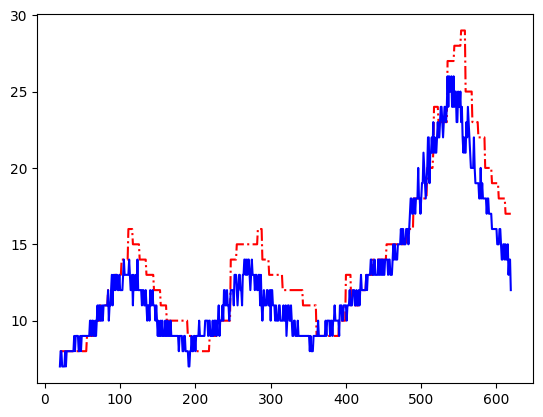

In [8]:
plt.plot([k for k, v in enumerate(fuzzy_merged_02["date"])][20:], fuzzy_merged_02["size"][20:], color="red", linestyle='dashdot', label='actual size')
plt.plot([k for k, v in enumerate(fuzzy_merged_02["date"])][20:], fuzzy_merged_02["expected_size"][20:], color="blue", label='expected size')

In [9]:
mean_squared_error(fuzzy_merged_02["size"], fuzzy_merged_02["expected_size"])


4.046774193548387

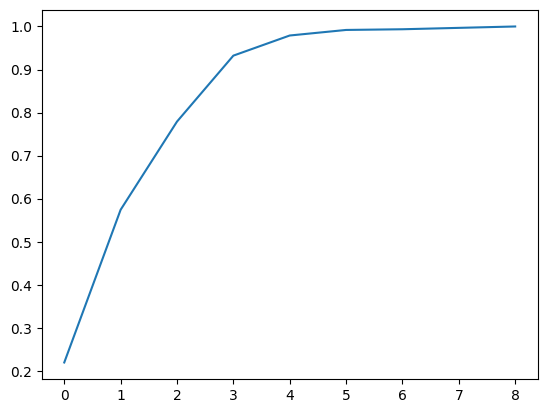

In [10]:
fuzzy_pmf = fuzzy_merged_02['diff'].value_counts(normalize=True).sort_index()
fuzzy_cdf = np.cumsum(fuzzy_pmf)
plt.plot(fuzzy_cdf)

In [11]:
std_cluster_size_01 = pd.read_csv("hpq_20221127121424.log", names=["date", "size"])
std_cluster_size_01

,date,size
0,2022-11-27T12:14:57+00:00,8
1,2022-11-27T12:14:58+00:00,8
2,2022-11-27T12:14:59+00:00,8
3,2022-11-27T12:15:00+00:00,8
4,2022-11-27T12:15:01+00:00,8
...,...,...
611,2022-11-27T12:26:22+00:00,30
612,2022-11-27T12:26:24+00:00,30
613,2022-11-27T12:26:25+00:00,30
614,2022-11-27T12:26:26+00:00,30


In [12]:
std_cluster_size_02 = std_cluster_size_01
std_cluster_size_02["date"] = pd.to_datetime(std_cluster_size_02["date"], utc = False) + pd.to_timedelta(9, unit='h')
std_cluster_size_02

,date,size
0,2022-11-27 21:14:57+00:00,8
1,2022-11-27 21:14:58+00:00,8
2,2022-11-27 21:14:59+00:00,8
3,2022-11-27 21:15:00+00:00,8
4,2022-11-27 21:15:01+00:00,8
...,...,...
611,2022-11-27 21:26:22+00:00,30
612,2022-11-27 21:26:24+00:00,30
613,2022-11-27 21:26:25+00:00,30
614,2022-11-27 21:26:26+00:00,30


In [13]:
std_request_01 = parse("simulation_ba2.log")
std_request_02 = std_request_01[std_request_01["status"] != "KO"]
std_request_02["date"] = pd.to_datetime(std_request_02["date"], utc=True)
std_request_02

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_10558/600845077.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_10558/3658772405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_request_02["date"] = pd.to_datetime(std_request_02["date"], utc=True)


,status,date,count
9,OK,2022-11-27 21:14:55+00:00,75.0
10,OK,2022-11-27 21:14:56+00:00,191.0
11,OK,2022-11-27 21:14:57+00:00,202.0
12,OK,2022-11-27 21:14:58+00:00,209.0
13,OK,2022-11-27 21:14:59+00:00,201.0
...,...,...,...
695,OK,2022-11-27 21:26:21+00:00,383.0
696,OK,2022-11-27 21:26:22+00:00,412.0
697,OK,2022-11-27 21:26:23+00:00,424.0
698,OK,2022-11-27 21:26:24+00:00,434.0


In [14]:
std_merged_01 = pd.merge(std_cluster_size_02, std_request_02, left_on="date", right_on="date")
std_merged_02 = std_merged_01
std_merged_02["expected_size"] = std_merged_01["count"].map(lambda x: reg_tree().predict([[x]])[0])
std_merged_02["diff"] = abs(std_merged_02["size"] - std_merged_02["expected_size"])
std_merged_02


,date,size,status,count,expected_size,diff
0,2022-11-27 21:14:57+00:00,8,OK,202.0,8.0,0.0
1,2022-11-27 21:14:58+00:00,8,OK,209.0,8.0,0.0
2,2022-11-27 21:14:59+00:00,8,OK,201.0,8.0,0.0
3,2022-11-27 21:15:00+00:00,8,OK,208.0,8.0,0.0
4,2022-11-27 21:15:01+00:00,8,OK,218.0,8.0,0.0
...,...,...,...,...,...,...
609,2022-11-27 21:26:20+00:00,30,OK,440.0,14.0,16.0
610,2022-11-27 21:26:21+00:00,30,OK,383.0,13.0,17.0
611,2022-11-27 21:26:22+00:00,30,OK,412.0,14.0,16.0
612,2022-11-27 21:26:24+00:00,30,OK,434.0,14.0,16.0


In [15]:
mean_squared_error(std_merged_02["size"], std_merged_02["expected_size"])


28.120521172638437

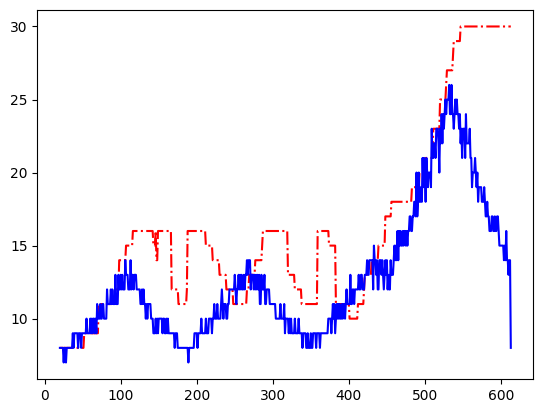

In [16]:
plt.plot([k for k, v in enumerate(std_merged_02["date"])][20:], std_merged_02["size"][20:], color="red", linestyle='dashdot', label='actual size')
plt.plot([k for k, v in enumerate(std_merged_02["date"])][20:], std_merged_02["expected_size"][20:], color="blue", label='expected size')

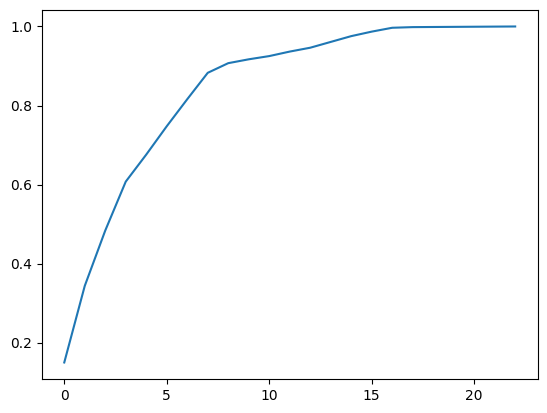

In [17]:
std_pmf = std_merged_02['diff'].value_counts(normalize=True).sort_index()
std_cdf = np.cumsum(std_pmf)
plt.plot(std_cdf)

In [18]:
sampen_cluster_size_01 = pd.read_csv("hpq_20221126135959.log", names=["date", "size"])
sampen_cluster_size_01

,date,size
0,2022-11-26T14:01:04+00:00,7
1,2022-11-26T14:01:05+00:00,7
2,2022-11-26T14:01:07+00:00,7
3,2022-11-26T14:01:08+00:00,7
4,2022-11-26T14:01:09+00:00,7
...,...,...
599,2022-11-26T14:12:31+00:00,28
600,2022-11-26T14:12:32+00:00,28
601,2022-11-26T14:12:34+00:00,28
602,2022-11-26T14:12:35+00:00,28


In [19]:
sampen_cluster_size_02 = sampen_cluster_size_01
sampen_cluster_size_02["date"] = pd.to_datetime(sampen_cluster_size_02["date"], utc = False) + pd.to_timedelta(9, unit='h')
sampen_cluster_size_02

,date,size
0,2022-11-26 23:01:04+00:00,7
1,2022-11-26 23:01:05+00:00,7
2,2022-11-26 23:01:07+00:00,7
3,2022-11-26 23:01:08+00:00,7
4,2022-11-26 23:01:09+00:00,7
...,...,...
599,2022-11-26 23:12:31+00:00,28
600,2022-11-26 23:12:32+00:00,28
601,2022-11-26 23:12:34+00:00,28
602,2022-11-26 23:12:35+00:00,28


In [20]:
sampen_request_01 = parse("simulation_bse.log")
sampen_request_02 = sampen_request_01[sampen_request_01["status"] != "KO"]
sampen_request_02["date"] = pd.to_datetime(sampen_request_02["date"], utc=True)
sampen_request_02

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_10558/600845077.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_10558/1770829219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampen_request_02["date"] = pd.to_datetime(sampen_request_02["date"], utc=True)


,status,date,count
26,OK,2022-11-26 23:01:04+00:00,26.0
27,OK,2022-11-26 23:01:05+00:00,233.0
28,OK,2022-11-26 23:01:06+00:00,183.0
29,OK,2022-11-26 23:01:07+00:00,209.0
30,OK,2022-11-26 23:01:08+00:00,214.0
...,...,...,...
712,OK,2022-11-26 23:12:30+00:00,422.0
713,OK,2022-11-26 23:12:31+00:00,406.0
714,OK,2022-11-26 23:12:32+00:00,385.0
715,OK,2022-11-26 23:12:33+00:00,414.0


In [21]:
sampen_merged_01 = pd.merge(sampen_cluster_size_02, sampen_request_02, left_on="date", right_on="date")
sampen_merged_02 = sampen_merged_01
sampen_merged_02["expected_size"] = sampen_merged_01["count"].map(lambda x: reg_tree().predict([[x]])[0])
sampen_merged_02["diff"] = abs(sampen_merged_02["size"] - sampen_merged_02["expected_size"])
sampen_merged_02


,date,size,status,count,expected_size,diff
0,2022-11-26 23:01:04+00:00,7,OK,26.0,4.0,3.0
1,2022-11-26 23:01:05+00:00,7,OK,233.0,9.0,2.0
2,2022-11-26 23:01:07+00:00,7,OK,209.0,8.0,1.0
3,2022-11-26 23:01:08+00:00,7,OK,214.0,8.0,1.0
4,2022-11-26 23:01:09+00:00,7,OK,194.0,8.0,1.0
...,...,...,...,...,...,...
597,2022-11-26 23:12:29+00:00,28,OK,420.0,14.0,14.0
598,2022-11-26 23:12:30+00:00,28,OK,422.0,14.0,14.0
599,2022-11-26 23:12:31+00:00,28,OK,406.0,14.0,14.0
600,2022-11-26 23:12:32+00:00,28,OK,385.0,13.0,15.0


In [22]:
mean_squared_error(sampen_merged_02["size"], sampen_merged_02["expected_size"])


27.69933554817276

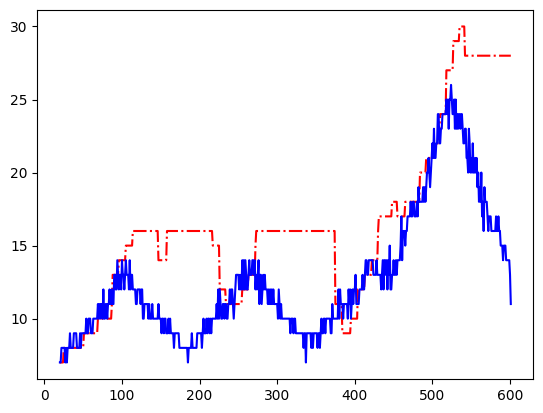

In [23]:
plt.plot([k for k, v in enumerate(sampen_merged_02["date"])][20:], sampen_merged_02["size"][20:], color="red", linestyle='dashdot', label='actual size')
plt.plot([k for k, v in enumerate(sampen_merged_02["date"])][20:], sampen_merged_02["expected_size"][20:], color="blue", label='expected size')

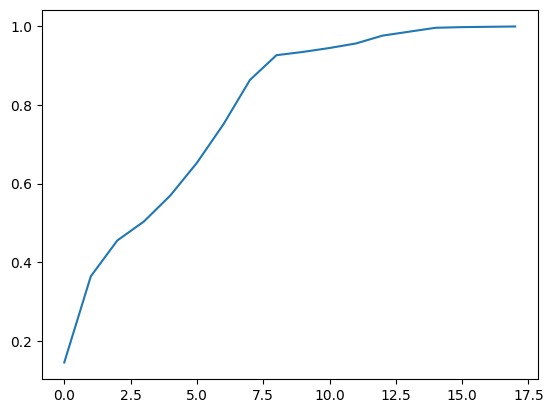

In [24]:
sampen_pmf = sampen_merged_02['diff'].value_counts(normalize=True).sort_index()
sampen_cdf = np.cumsum(sampen_pmf)
plt.plot(sampen_cdf)

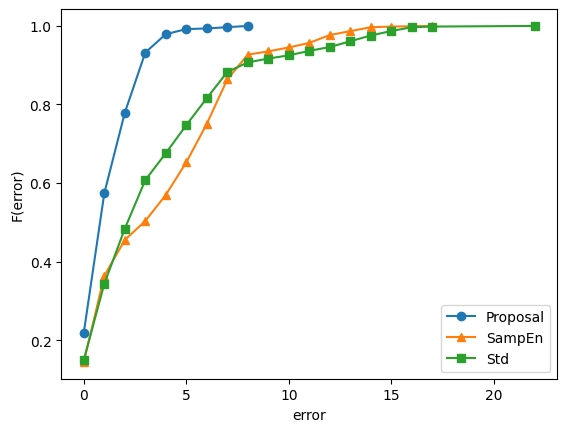

In [25]:
plt.xlabel(xlabel="error")
plt.ylabel(ylabel="F(error)")

plt.plot(fuzzy_cdf, "o-", label='Proposal')
plt.plot(sampen_cdf, "^-", label='SampEn')
plt.plot(std_cdf, "s-", label='Std')

plt.legend()